In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import datetime

#### Text analysis output and recommendation

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import certifi
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.poolmanager import PoolManager
import ssl


class SSLAdapter(HTTPAdapter):
    def init_poolmanager(self, *args, **kwargs):
        context = ssl.create_default_context(cafile=certifi.where())
        self.poolmanager = PoolManager(*args, ssl_context=context, **kwargs)


# Function to calculate RSI
def calculate_rsi(data, window):
    delta = data["Close"].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# Function to calculate MACD
def calculate_macd(data):
    exp1 = data["Close"].ewm(span=12, adjust=False).mean()
    exp2 = data["Close"].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal


# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window):
    data["MA"] = data["Close"].rolling(window=window).mean()
    data["STD"] = data["Close"].rolling(window=window).std()
    data["Upper Band"] = data["MA"] + (data["STD"] * 2)
    data["Lower Band"] = data["MA"] - (data["STD"] * 2)
    return data


# Get the most recent complete trading day
def get_last_trading_day():
    now = datetime.now()
    last_trading_day = now
    if now.weekday() >= 5:  # If today is Saturday or Sunday
        last_trading_day -= timedelta(days=now.weekday() - 4)
    else:
        last_trading_day -= timedelta(days=1)
    while last_trading_day.weekday() >= 5:  # Adjust for weekends
        last_trading_day -= timedelta(days=1)
    return last_trading_day.strftime("%Y-%m-%d")


# Parameter configuration
start_date = "2019-01-01"
end_date = get_last_trading_day()
tickers = [
    "AAPL",
    "NVDA",
    "TSLA",
    "MRNA",
    "BNTX",
    "AMZN",
    "NKE",
    "GOOGL",
    "LVMH",
    "MBIO",
]

# Create a session with the SSL adapter
session = requests.Session()
session.mount("https://", SSLAdapter())

# Analyze each stock and store results
results = []

for ticker in tickers:
    try:
        # Download historical data
        data = yf.download(ticker, start=start_date, end=end_date, session=session)
        if data.empty:
            print(f"No data available for {ticker}. Skipping.")
            continue

        # Calculate Moving Averages
        data["MA10"] = data["Close"].rolling(window=10).mean()
        data["MA50"] = data["Close"].rolling(window=50).mean()

        # Calculate RSI
        data["RSI"] = calculate_rsi(data, window=14)

        # Calculate MACD
        data["MACD"], data["Signal"] = calculate_macd(data)

        # Calculate Bollinger Bands
        data = calculate_bollinger_bands(data, window=20)

        # Retrieve fundamental data from Yahoo Finance
        stock = yf.Ticker(ticker)
        pe_ratio = stock.info.get("trailingPE", np.nan)
        eps = stock.info.get("trailingEps", np.nan)
        revenue_growth = stock.info.get("revenueGrowth", np.nan)

        # Simple scoring based on technical analysis
        rsi_score = (
            1 if data["RSI"].iloc[-1] < 30 else -1 if data["RSI"].iloc[-1] > 70 else 0
        )
        macd_score = 1 if data["MACD"].iloc[-1] > data["Signal"].iloc[-1] else 0
        total_score = rsi_score + macd_score

        results.append(
            {
                "Ticker": ticker,
                "Current Price": data["Close"].iloc[-1],
                "MA10": data["MA10"].iloc[-1],
                "MA50": data["MA50"].iloc[-1],
                "RSI": data["RSI"].iloc[-1],
                "MACD": data["MACD"].iloc[-1],
                "Signal": data["Signal"].iloc[-1],
                "Upper Band": data["Upper Band"].iloc[-1],
                "Lower Band": data["Lower Band"].iloc[-1],
                "P/E Ratio": pe_ratio,
                "EPS": eps,
                "Revenue Growth": revenue_growth,
                "Total Score": total_score,
            }
        )
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Convert results to DataFrame and sort by total score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Total Score", ascending=False)

# Display the results
print("Metrics for each stock:")
print(results_df)

# Display the top two stocks
top_two_stocks = results_df.head(2)
print("Top two stocks to consider for the next trading day:")
print(
    top_two_stocks[
        [
            "Ticker",
            "Current Price",
            "MA10",
            "MA50",
            "RSI",
            "MACD",
            "Signal",
            "Upper Band",
            "Lower Band",
            "P/E Ratio",
            "EPS",
            "Revenue Growth",
            "Total Score",
        ]
    ]
)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error processing AAPL: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v10/finance/quoteSummary/AAPL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AAPL&crumb=qmL38KOPiVO (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000021FAC00A840>, 'Connection to query2.finance.yahoo.com timed out. (connect timeout=30)'))



[*********************100%%**********************]  1 of 1 completed

Error processing NVDA: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v10/finance/quoteSummary/NVDA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NVDA&crumb=qmL38KOPiVO (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000021FAC0097F0>, 'Connection to query2.finance.yahoo.com timed out. (connect timeout=30)'))



[*********************100%%**********************]  1 of 1 completed

Error processing TSLA: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v10/finance/quoteSummary/TSLA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TSLA&crumb=qmL38KOPiVO (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000021FAC00B4D0>, 'Connection to query2.finance.yahoo.com timed out. (connect timeout=30)'))



[*********************100%%**********************]  1 of 1 completed

Error processing MRNA: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v10/finance/quoteSummary/MRNA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MRNA&crumb=qmL38KOPiVO (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000021FABFD79B0>, 'Connection to query2.finance.yahoo.com timed out. (connect timeout=30)'))



[*********************100%%**********************]  1 of 1 completed

Error processing BNTX: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v10/finance/quoteSummary/BNTX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BNTX&crumb=qmL38KOPiVO (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000021FAC008EC0>, 'Connection to query2.finance.yahoo.com timed out. (connect timeout=30)'))



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LVMH']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


No data available for LVMH. Skipping.
Metrics for each stock:
  Ticker  Current Price        MA10        MA50        RSI      MACD  \
0   AMZN     183.660004  183.692999  183.011000  56.362064  0.642318   
1    NKE      93.389999   94.885001   93.080400  56.972781  0.422602   
3   MBIO       0.130000    0.154300    0.302280  31.481482 -0.058788   
2  GOOGL     176.789993  175.492998  167.628599  54.459846  2.367099   

     Signal  Upper Band  Lower Band  P/E Ratio   EPS  Revenue Growth  \
0  0.312619  188.506390  176.811609  51.557423  3.57           0.125   
1  0.422173   96.939292   90.404708  27.941175  3.40           0.003   
3 -0.063444    0.322273    0.078127        NaN -4.40             NaN   
2  2.778313  178.730384  172.028614  27.184050  6.52           0.154   

   Total Score  
0            1  
1            1  
3            1  
2            0  
Top two stocks to consider for the next trading day:
  Ticker  Current Price        MA10      MA50        RSI      MACD    Signal  

#### Visualisation

[*********************100%%**********************]  1 of 1 completed

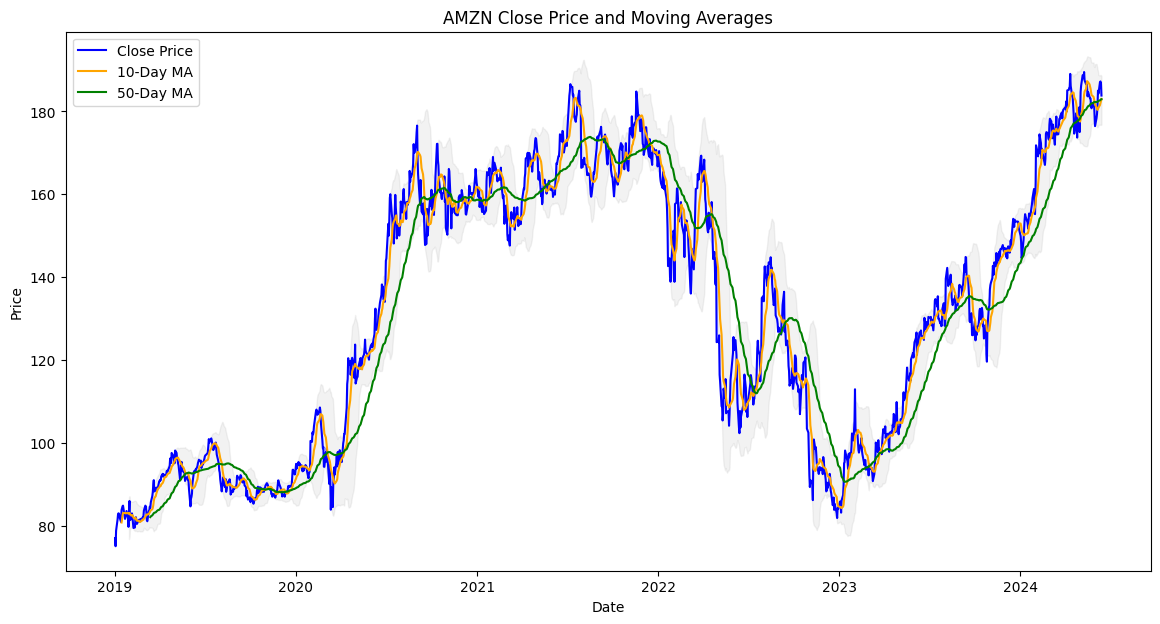

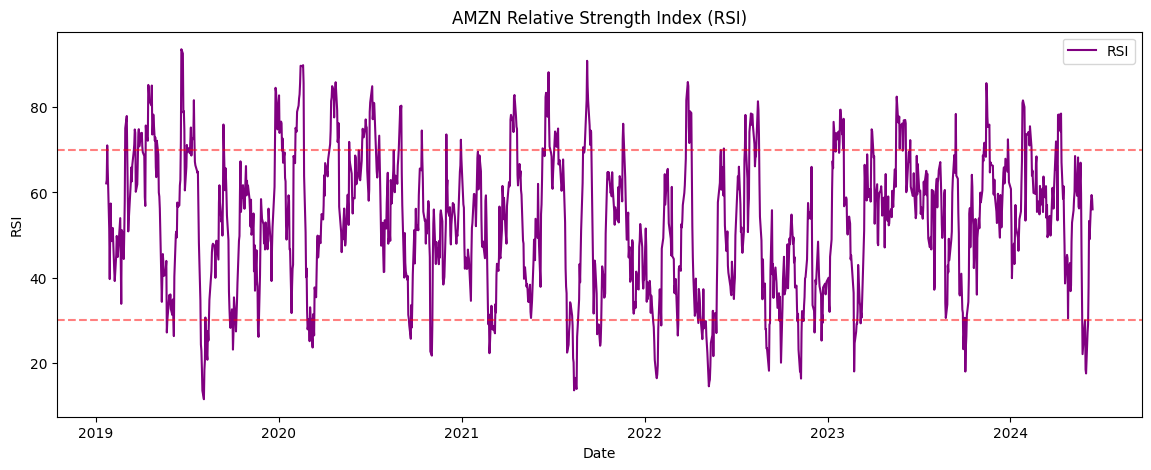

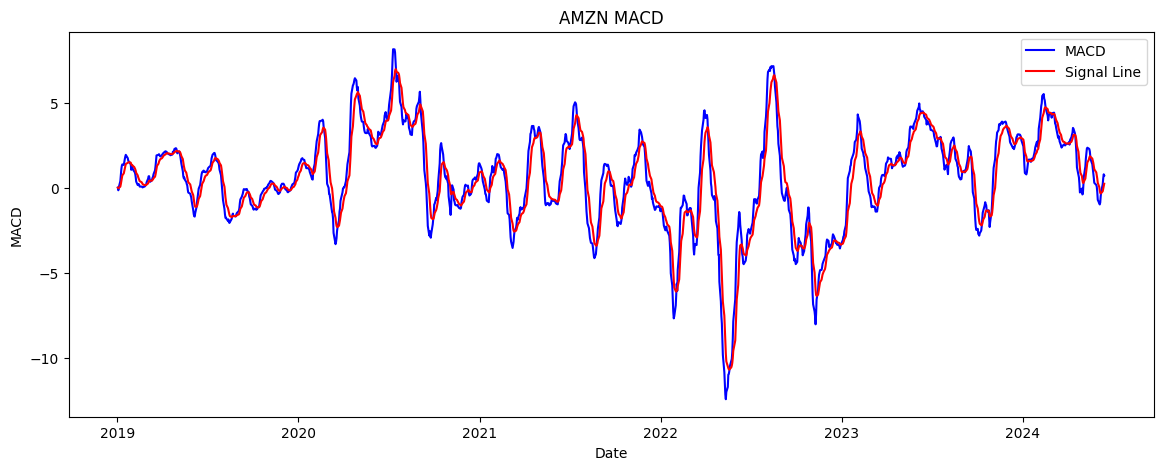

[*********************100%%**********************]  1 of 1 completed


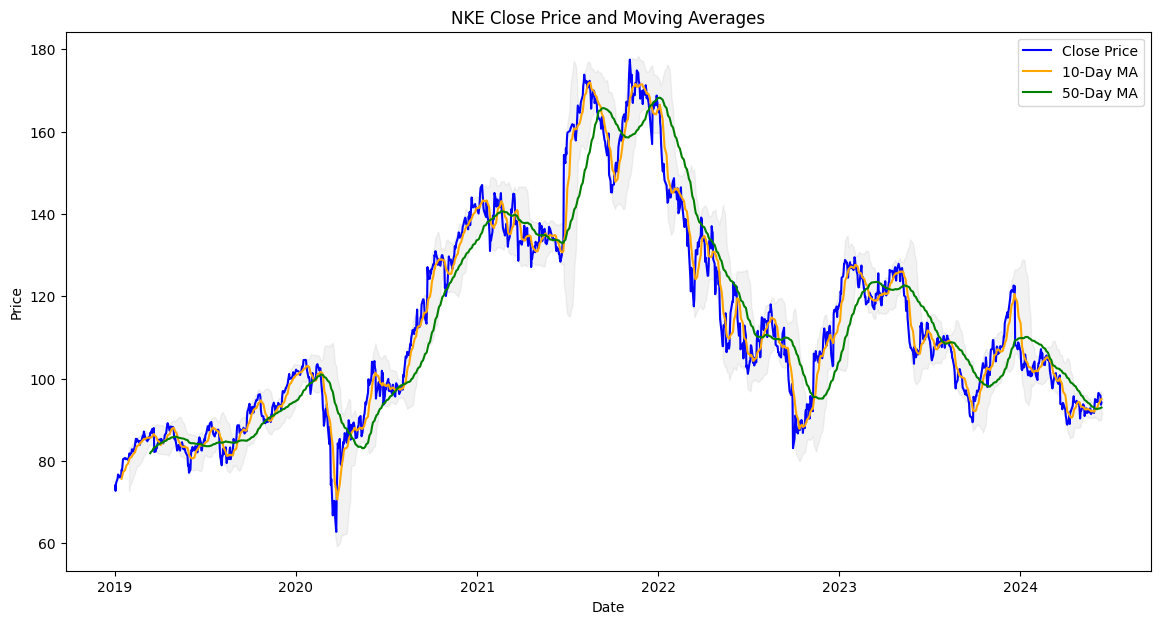

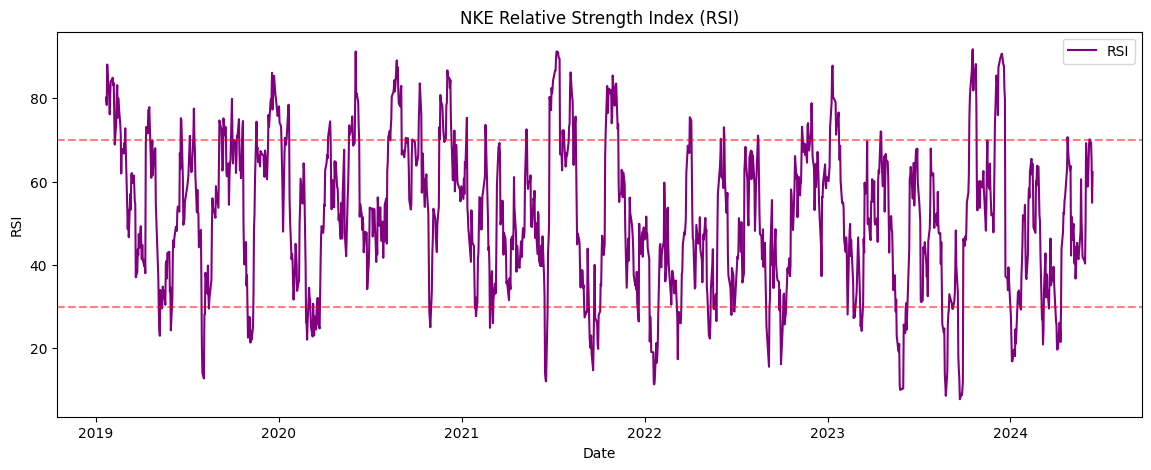

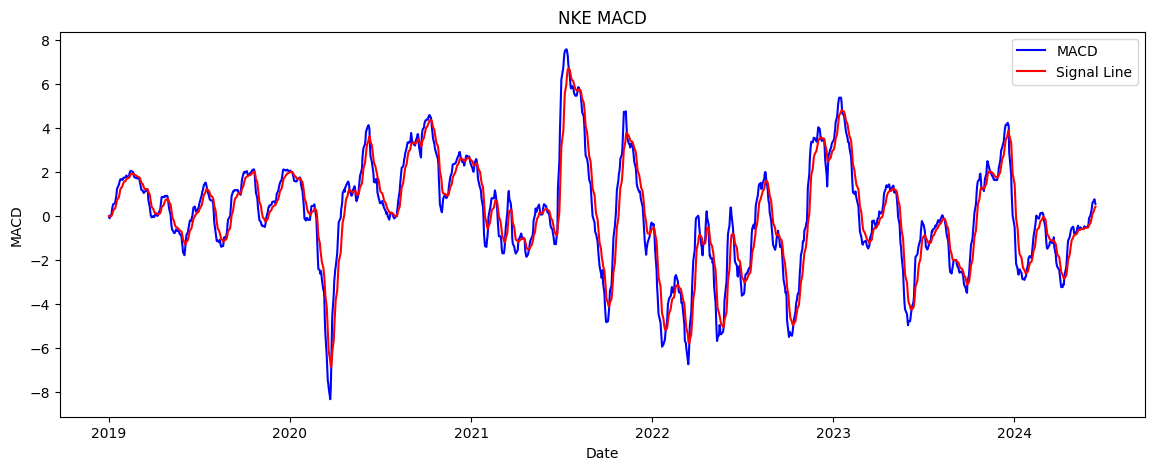

In [54]:
import matplotlib.pyplot as plt

# Visualize the top two stocks
for ticker in top_two_stocks["Ticker"]:
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    data["MA10"] = data["Close"].rolling(window=10).mean()
    data["MA50"] = data["Close"].rolling(window=50).mean()
    data["RSI"] = calculate_rsi(data, window=14)
    data["MACD"], data["Signal"] = calculate_macd(data)
    data = calculate_bollinger_bands(data, window=20)

    plt.figure(figsize=(14, 7))
    plt.plot(data["Close"], label="Close Price", color="blue")
    plt.plot(data["MA10"], label="10-Day MA", color="orange")
    plt.plot(data["MA50"], label="50-Day MA", color="green")
    plt.fill_between(
        data.index, data["Lower Band"], data["Upper Band"], color="grey", alpha=0.1
    )
    plt.title(f"{ticker} Close Price and Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(data["RSI"], label="RSI", color="purple")
    plt.axhline(30, linestyle="--", alpha=0.5, color="red")
    plt.axhline(70, linestyle="--", alpha=0.5, color="red")
    plt.title(f"{ticker} Relative Strength Index (RSI)")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(data["MACD"], label="MACD", color="blue")
    plt.plot(data["Signal"], label="Signal Line", color="red")
    plt.title(f"{ticker} MACD")
    plt.xlabel("Date")
    plt.ylabel("MACD")
    plt.legend()
    plt.show()

In [4]:
# Add Volume analysis to your existing code
data["Volume_MA10"] = data["Volume"].rolling(window=10).mean()

In [5]:
# Example of setting stop-loss and take-profit orders
current_price = data["Close"].iloc[-1]
stop_loss = current_price * 0.98  # 2% below current price
take_profit = current_price * 1.10  # 10% above current price

print(f"Stop-Loss: {stop_loss}")
print(f"Take-Profit: {take_profit}")

Stop-Loss: 0.13230000525712968
Take-Profit: 0.14850000590085985
